# Cells below allow to run our code in Colab easily. Enjoy! :)

In [1]:
!git clone https://github.com/82492749123082/farich-pics.git -b dev #clone dev-branch
%cd farich-pics
!pip install gdown -q #install package

Cloning into 'farich-pics'...
remote: Enumerating objects: 285, done.
remote: Counting objects: 100% (285/285), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 285 (delta 130), reused 221 (delta 77), pack-reused 0
Receiving objects: 100% (285/285), 915.59 KiB | 3.42 MiB/s, done.
Resolving deltas: 100% (130/130), done.
/content/farich-pics


In [0]:
url_dataset, dataset_path = "1V1r0P1QMRpoYhI1tKcGnWXEjdutjXcIV", "dataset.pkl" #many circles dataset
url_nn, path_nn = "1gQtXr_WBY54sFpwNK-XLISqGiPMyzVvj", "nn.pth"

In [3]:
!gdown --id $url_dataset -O $dataset_path
!gdown --id $url_nn -O $path_nn

Downloading...
From: https://drive.google.com/uc?id=1V1r0P1QMRpoYhI1tKcGnWXEjdutjXcIV
To: /content/farich-pics/dataset.pkl
99.2MB [00:00, 149MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1gQtXr_WBY54sFpwNK-XLISqGiPMyzVvj
To: /content/farich-pics/nn.pth
176MB [00:01, 96.9MB/s]


# Now define the dataset:

First open our raw data for train & test stored in pickle file:

In [0]:
import pickle

with open(dataset_path, "rb") as f:
    H_res, h_res, mask_res = pickle.load(f)

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Ellipse, Circle, Rectangle

%matplotlib inline

In [6]:
len(h_res)

10000

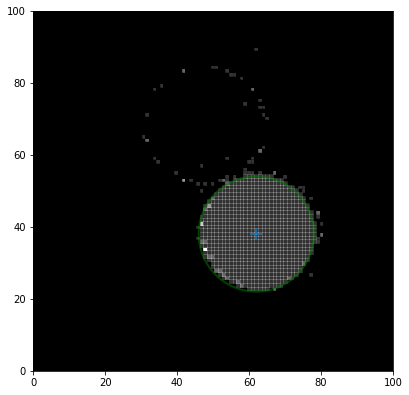

In [7]:
loc_ind = 1390
num_of_circles = 2
xv = h_res[loc_ind][num_of_circles-1][0]
yv = h_res[loc_ind][num_of_circles-1][1]
r = h_res[loc_ind][num_of_circles-1][2]

fig = plt.figure(frameon=False, figsize=(5, 5) )

H = H_res[loc_ind].toarray()
ax = plt.Axes(fig, [0., 0., 1., (H.shape[1]/H.shape[0])])
# ax.set_axis_off()
fig.add_axes(ax)

xedges = np.linspace(0, H.shape[0], H.shape[0])
yedges = np.linspace(0, H.shape[1], H.shape[1])
Xg, Yg = np.meshgrid(xedges, yedges)
e = Circle(xy=(xv, yv), radius=r, linewidth=2, fill=False, edgecolor='green', alpha=0.5)
ax.pcolormesh(Xg, Yg, H, cmap='gray')
ax.pcolormesh(Xg, Yg, mask_res[loc_ind][1].toarray(), cmap='gray', alpha=0.2)
ax.add_artist(e)
plt.scatter(xv, yv, marker='+', s=150)

Then create the class instance:

In [0]:
import torch
from farichlib.Dataset import Dataset

In [0]:
data = Dataset(noise_level=0.01) #add noise to data
data.load(dataset_path)

In [11]:
data[0] #check

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 {'area': tensor([1239.0398,  948.6401,  948.6401]),
  'boxes': tensor([[48.4000, 11.4000, 83.6000, 46.6000],
          [14.6000, 33.6000, 45.4000, 64.4000],
          [30.6000, 32.6000, 61.4000, 63.4000]]),
  'image_id': tensor([0]),
  'labels': tensor([1, 1, 1]),
  'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0.

# Defining our pre-trained model:

In [0]:
import torchvision
import math
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model(load_trained=None):
    if load_trained is None:
        num_classes = 2
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
        return model
    return torch.load(load_trained)

In [0]:
model = get_model(path_nn) #use pretrained model on noiseless data

# Train the model on data with noise

In [0]:
from farichlib import utils

In [0]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train(mode=True)
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

# Putting everything together

In [0]:
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(data)).tolist()
dataset = torch.utils.data.Subset(data, indices[:500]) #yes, only 500 images in train set | but it's enough
dataset_test = torch.utils.data.Subset(data, indices[500:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Let's train for 5 epoch  

In [18]:
# let's train it for 5 epoch
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 50 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/250]  eta: 0:06:05  lr: 0.000025  loss: 0.0610 (0.0610)  loss_classifier: 0.0036 (0.0036)  loss_box_reg: 0.0005 (0.0005)  loss_mask: 0.0564 (0.0564)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 1.4621  data: 0.1489  max mem: 1635
Epoch: [0]  [ 50/250]  eta: 0:01:02  lr: 0.001028  loss: 0.1048 (0.1139)  loss_classifier: 0.0077 (0.0105)  loss_box_reg: 0.0049 (0.0063)  loss_mask: 0.0911 (0.0953)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0013 (0.0016)  time: 0.2863  data: 0.0056  max mem: 2041
Epoch: [0]  [100/250]  eta: 0:00:44  lr: 0.002031  loss: 0.1100 (0.1141)  loss_classifier: 0.0098 (0.0108)  loss_box_reg: 0.0061 (0.0063)  loss_mask: 0.0913 (0.0952)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0015 (0.0016)  time: 0.2890  data: 0.0056  max mem: 2041
Epoch: [0]  [150/250]  eta: 0:00:29  lr: 0.003034  loss: 0.1090 (0.1148)  loss_classifier: 0.0082 (0.0107)  loss_box_reg: 0.0045 (0.0065)  loss_mask: 0.0977 (0.0957) 

In [0]:
from farichlib.utils import iou_score, show_nn_result

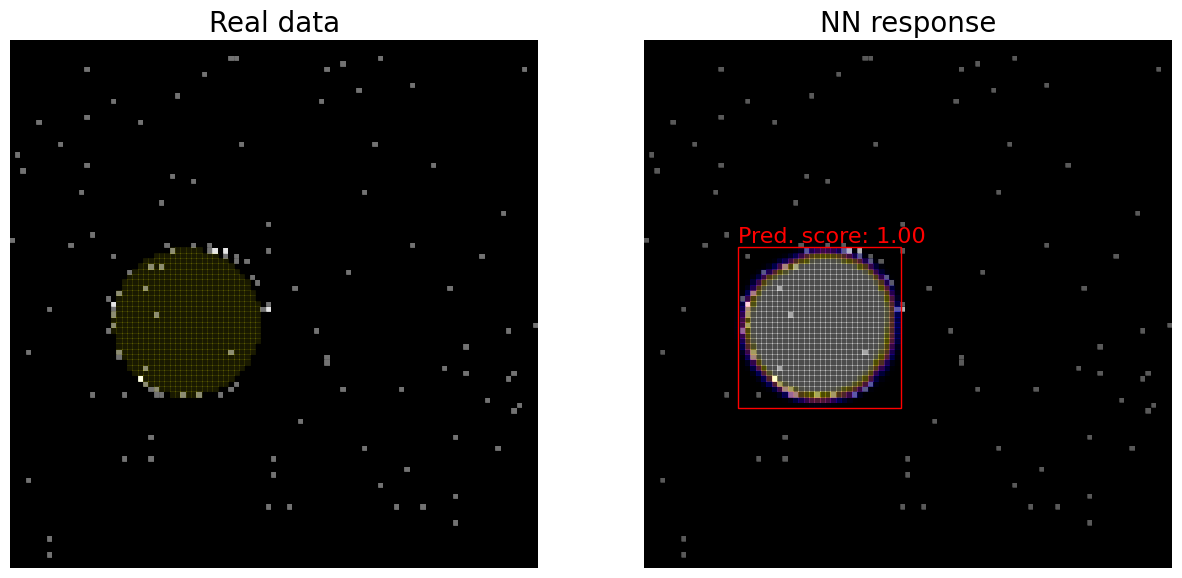

In [23]:
ind = random.randint(0, len(dataset_test)-1)
show_nn_result(model, dataset_test[ind], 0.99)

# Now let's analyze the result

Будем считать, что если IoU истинной и предсказанной масок больше iou_thr (в нашем случае 0.8), то они соответствуют одному и тому же кругу

Также будем использовать скор нейросети, равный 0.9

Хотим найти recall в зависимости от истинного числа кругов

In [0]:
def iou_score2(mask1, masks2):
    masks1 = np.broadcast_to(mask1, masks2.shape)
    inter = np.logical_and(masks1, masks2).sum(axis=(1,2))
    union = np.logical_or(masks1, masks2).sum(axis=(1,2))
    return inter/union

In [0]:
def iou_imgage(index, nn_thr=0.9):
    img, bbox = dataset_test[index]
    masks1 = bbox['masks'][:].numpy().astype('bool')
    model.eval()
    prediction = model([img.to(device)])
    try:
        masks2 = (prediction[0]['masks'][:,0].cpu().detach().numpy() > 0.5).astype('bool')
        scores = prediction[0]['scores'].cpu().detach().numpy()
    except:
        return np.array([[]])
    rates = []
    for mask1 in masks1:
      rates.append(iou_score2(mask1, masks2))
    # appending scores to the end
    rates.append(scores)
    return rates

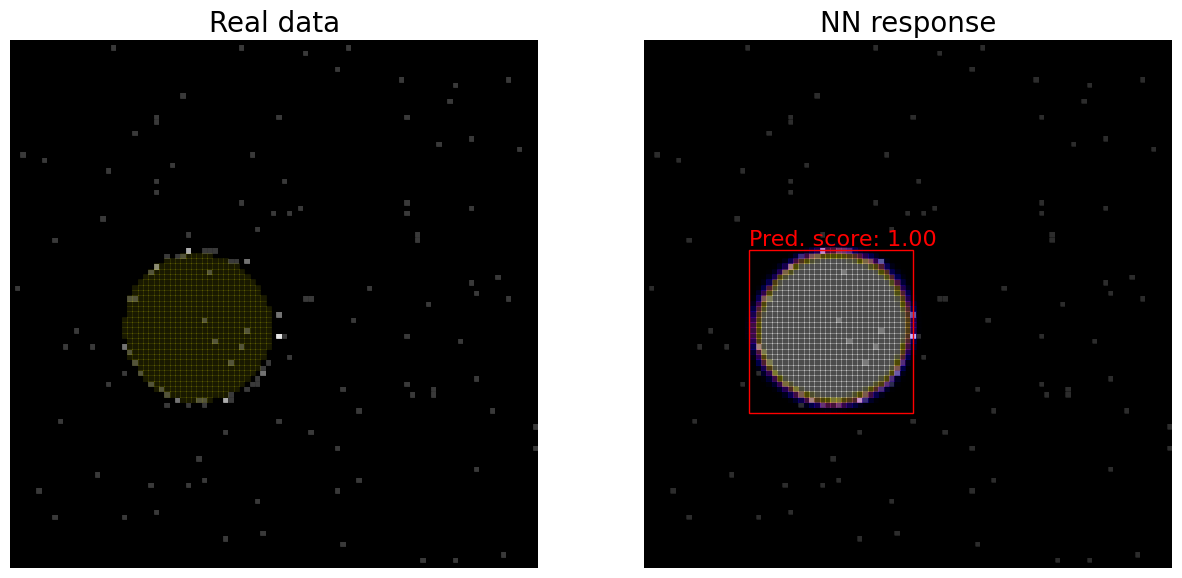

In [26]:
ind = 0
show_nn_result(model, dataset_test[ind], 0.99)

In [27]:
r = iou_imgage(0)
r

[array([0.9183056]), array([0.9999844], dtype=float32)]

In [0]:
n_images = 1000
iou_thr = 0.8
r = [ iou_imgage(i) for i in range(0,n_images)]

In [0]:
def n_circles(r, iou_thr, nn_thr):
  arr = np.array( [r[i] for i in range(len(r)-1)] )
  try:
    b = np.array( [1*((row == np.max(row)) & (row > iou_thr)) for row in arr] )
  except:
    return -1,-1
  nn_goodness = 1*(r[-1] > nn_thr)
  is_good_circle = ( np.sum(b, axis=0)==1 ) & nn_goodness
  is_bad_circle = ( np.sum(b, axis=0)!=1 ) & nn_goodness
  return  np.sum( is_good_circle ), np.sum( is_bad_circle ) 

In [30]:
u = 2
r[u], n_circles(r[u], 0.8, 0.11)

([array([0.94578313, 0.        , 0.19171287, 0.        ]),
  array([0.        , 0.92366412, 0.1304726 , 0.36902486]),
  array([0.99997985, 0.99997234, 0.13654393, 0.07506457], dtype=float32)],
 (2, 1))

In [0]:
recall_tot = [0,0,0]
precision_tot = [0,0,0]
n_tot = [0,0,0]
n_nn_tot = [0,0,0]
for elem in r:
  index = len(elem)-2 # 0 for 1 circle, 1 --- for 2, 2 --- for 3 circles
  tp_fn = len(elem)-1 
  tp, fp = n_circles(elem, iou_thr=0.8, nn_thr=0)
  if tp+fp<0:
    continue
  tp_fp = tp+fp
  n_tot[index] += tp_fn
  n_nn_tot[index] += tp_fp
  recall_tot[index] += tp 
  precision_tot[index] += tp 

In [0]:
for i in range(3):
  recall_tot[i] = recall_tot[i]/n_tot[i]
  precision_tot[i] = precision_tot[i]/n_nn_tot[i]

In [33]:
recall_tot, precision_tot

([1.0, 0.9552469135802469, 0.8999028182701652],
 [0.7081545064377682, 0.7351543942992874, 0.7084927314460597])

Теперь узнаем, как всё это (precision, recall) зависит от скора нейронной сети 

In [0]:
def evaluate_metrics(r, precision, recall, threshold):
  recall_tot = np.array([0.,0.,0.])
  precision_tot = np.array([0.,0.,0.])
  n_tot = [0,0,0]
  n_nn_tot = [0,0,0]
  for elem in r:
    index = len(elem)-2 # 0 for 1 circle, 1 --- for 2,kinogo.by 2 --- for 3 circles
    tp_fn = len(elem)-1 
    tp, fp = n_circles(elem, iou_thr=0.8, nn_thr=threshold)
    tp_fp = tp + fp
    n_tot[index] += tp_fn
    n_nn_tot[index] += tp_fp
    recall_tot[index] += tp 
    precision_tot[index] += tp 
  for i in range(3):
    recall_tot[i] = recall_tot[i]/n_tot[i]
    precision_tot[i] = precision_tot[i]/n_nn_tot[i]
  precision = np.concatenate((precision, precision_tot))
  recall = np.concatenate((recall, recall_tot)) 
  return precision, recall

In [0]:
precision = np.array([])
recall = np.array([])
threshold = np.linspace(0, 0.999, 90)
for thr in threshold:
  precision, recall = evaluate_metrics(r=r, precision=precision, recall=recall, threshold=thr)
precision = np.reshape(precision, (-1,3))
recall = np.reshape(recall, (-1,3))

In [0]:
precision1, precision2, precision3 = precision[:,0], precision[:,1], precision[:,2] 
recall1, recall2, recall3 = recall[:,0], recall[:,1], recall[:,2]

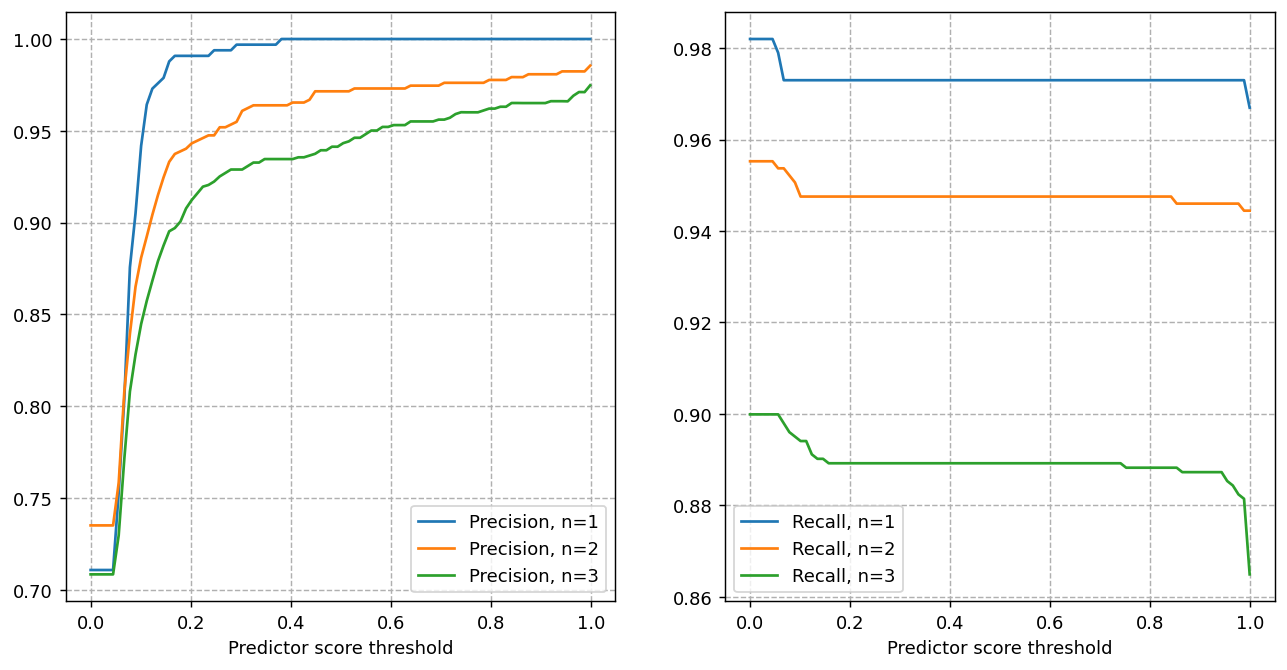

In [37]:
plt.figure(dpi=130,figsize=(12,6))
plt.subplot(121)
plt.plot(threshold, precision1, label='Precision, n=1')
plt.plot(threshold, precision2, label='Precision, n=2')
plt.plot(threshold, precision3, label='Precision, n=3')
plt.grid(linestyle='--')
plt.xlabel('Predictor score threshold')
plt.legend()
plt.subplot(122)
plt.plot(threshold, recall1, label='Recall, n=1')
plt.plot(threshold, recall2, label='Recall, n=2')
plt.plot(threshold, recall3, label='Recall, n=3')
plt.grid(linestyle='--')
plt.xlabel('Predictor score threshold')
plt.legend()

In [38]:
lens = []
for i in range(1000):
  img, bbox = dataset_test[i]
  lens.append(len(bbox['masks'][:]))
np.unique(np.array(lens), return_counts=True)

(array([1, 2, 3]), array([333, 324, 343]))